In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib
%matplotlib inline

/Library/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
NUMBER_OF_ZONES = 24
NUMBER_OF_NODES = 24
NUMBER_OF_EDGES = 76
#have to read out from file

In [3]:
net = pd.read_csv('./TransportationNetworks/SiouxFalls/SiouxFalls_net.tntp', sep='\t', header=5)
best_flow = pd.read_csv('./TransportationNetworks/SiouxFalls/SiouxFalls_flow.tntp', sep='\t')

In [4]:
del net[';']
del net['~ ']
net.head()

,Init node,Term node,Capacity,Length,Free Flow Time,B,Power,Speed limit,Toll,Type
0,1,2,25900.200640,6,6,0.15,4,0,0,1
1,1,3,23403.473190,4,4,0.15,4,0,0,1
2,2,1,25900.200640,6,6,0.15,4,0,0,1
3,2,6,4958.180928,5,5,0.15,4,0,0,1
4,3,1,23403.473190,4,4,0.15,4,0,0,1


In [5]:
f = open('./TransportationNetworks/SiouxFalls/SiouxFalls_trips.tntp')
cnt = 0
f_rec = open('./TransportationNetworks/SiouxFalls/splitted_trips/trip_%d.tntp'%(cnt), 'w')
for line in f.readlines():
    if 'Origin' in line:
        f_rec.close()
        f_rec = open('./TransportationNetworks/SiouxFalls/splitted_trips/trip_%d.tntp'%(cnt),'w')
        cnt += 1
    else:
        f_rec.write(line)
f_rec.close()

In [6]:
trips = np.zeros((NUMBER_OF_ZONES, NUMBER_OF_ZONES))
for i in range(cnt):
    f = open('./TransportationNetworks/SiouxFalls/splitted_trips/trip_%d.tntp'%(i))
    for line in f.readlines():
        for item in line.split(';'):
            if not '\n' in item :
                kv = item.split(':')
                trips[i, int(kv[0])-1] = float(kv[1])

In [7]:
net_zones = net[(net['Init node '] <= 110) | (net['Term node '] <= 110)]
net_links = net[(net['Init node '] > 110) | (net['Term node '] > 110)]

In [8]:
import networkx
mu = 1./4
gamma = 1.

def get_new_weight(init_weight, init_cap, cap):
    return init_weight*(1 + gamma*(float(cap)/float(init_cap))**(1/mu))
## do we need normalize the capacities?

In [9]:
initcost = networkx.from_pandas_dataframe(df=net, source='Init node ', target='Term node ', edge_attr='Free Flow Time ')
editedcost = networkx.from_pandas_dataframe(df=net, source='Init node ', target='Term node ', edge_attr='Free Flow Time ')
capacity = networkx.from_pandas_dataframe(df=net, source='Init node ', target='Term node ', edge_attr='Capacity ')
flow = np.zeros((NUMBER_OF_NODES, NUMBER_OF_NODES))

## Frank Wolf

In [10]:
shpaths = {}
for i in range(NUMBER_OF_ZONES):
    shpaths[i+1] = networkx.single_source_dijkstra_path(editedcost, source=i+1, weight='Free Flow Time ')

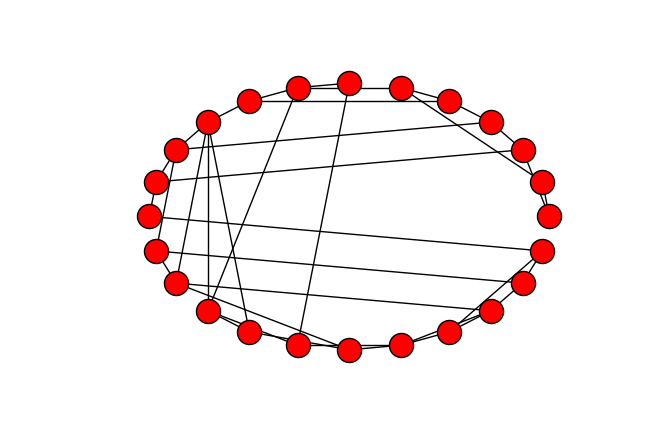

In [11]:
networkx.draw_circular(editedcost)

In [12]:
for i,j in itertools.product(range(NUMBER_OF_ZONES), repeat = 2):
    if(trips[i][j] != 0):
        for fpnode, fnnode in zip(shpaths[i+1][j+1][:-1], shpaths[i+1][j+1][1:]):
            pnode = int(fpnode)
            nnode = int(fnnode)
            flow[int(pnode)-1][int(nnode)-1] += trips[i][j]
            
for i,j in itertools.product(range(NUMBER_OF_ZONES), repeat = 2):
        for fpnode, fnnode in zip(shpaths[i+1][j+1][:-1], shpaths[i+1][j+1][1:]):
            pnode = int(fpnode)
            nnode = int(fnnode)
            editedcost[pnode][nnode]['Free Flow Time '] = get_new_weight(initcost[pnode][nnode]['Free Flow Time '],
                                                      capacity[pnode][nnode]['Capacity '], flow[pnode-1][nnode-1])

In [ ]:
cnt = 1
while cnt<1000:
    newflow = np.zeros((NUMBER_OF_NODES, NUMBER_OF_NODES))
    gm = 1./(cnt+1)
    shpaths = {}
    for i in range(NUMBER_OF_ZONES):
        shpaths[i+1] = networkx.single_source_dijkstra_path(editedcost, source=i+1, weight='Free Flow Time ')
    
    for i,j in itertools.product(range(NUMBER_OF_ZONES), repeat = 2):   
        for fpnode, fnnode in zip(shpaths[i+1][j+1][:-1], shpaths[i+1][j+1][1:]):
            pnode = int(fpnode)
            nnode = int(fnnode)
            newflow[pnode-1][nnode-1] += trips[i][j]
            
    #print ("oldflow - %lf, newflow - %lf")%(flow[0,1], newflow[0,1]) 
    flow = flow * (1-gm) + gm * newflow     
    
    for i,j in itertools.product(range(NUMBER_OF_ZONES), repeat = 2):   
        for fpnode, fnnode in zip(shpaths[i+1][j+1][:-1], shpaths[i+1][j+1][1:]):
            pnode = int(fpnode)
            nnode = int(fnnode)
            editedcost[pnode][nnode]['Free Flow Time '] = get_new_weight(initcost[pnode][nnode]['Free Flow Time '],
                                                          capacity[pnode][nnode]['Capacity '],
                                                          flow[pnode-1][nnode-1])


    cnt += 1

    if cnt % 50 == 0: 
        print cnt

## Mirror descent

In [13]:
cumulative_trips = 360600.0
#already got trips adjmat
mu = 1./4
eps = 0.5

In [14]:
edges_as_v = net[['Init node ', 'Term node ']].as_matrix()
times_as_v = net['Free Flow Time '].as_matrix()
freetimes_as_v = net['Free Flow Time '].as_matrix()
flows_as_v = net['Capacity '].as_matrix()
capacity_as_v = net['Capacity '].as_matrix()

edges_dict = {}

for num, edge in enumerate(edges_as_v):
    edges_dict[(edge[0], edge[1])] = num + 1

cost = networkx.from_pandas_dataframe(df=net, source='Init node ', target='Term node ', edge_attr='Free Flow Time ')
##already have capacity graph

In [15]:
trips[23]

array([  100.,     0.,     0.,   200.,     0.,   100.,   100.,   200.,
         200.,   800.,   600.,   500.,   700.,   400.,   400.,   300.,
         300.,     0.,   100.,   400.,   500.,  1100.,   700.,     0.])

In [16]:
def seed(arr):
    ret = np.zeros(NUMBER_OF_ZONES+1)
    ret2 = np.zeros(NUMBER_OF_ZONES)
    ret[0] = 0
    for i in range(1, NUMBER_OF_ZONES+1):
        ret[i] = np.sum(arr[i-1])
        ret2[i-1] = ret[i]
        ret[i] += ret[i-1]
    return ret, ret2

def get_num(seed, val):
    for num, (sl,sg) in enumerate(zip(seed[:-1], seed[1:])):
        if val >= sl and val <= sg:
            return num
    
seed_trips, V_trips = seed(trips)
print V_trips

def dF(g, cap_g, trips):
    choice = get_num(seed_trips, np.random.uniform(low=0, high=cumulative_trips))
    paths = networkx.single_source_dijkstra_path(g, source=choice+1, weight='Free Flow Time ')
    ret = np.zeros(NUMBER_OF_EDGES)
    ## need or not?
    ###ret += cap_g
    for numV, V in enumerate(trips[choice]):
        if V!=0:
            
            ##setting up partly ones here
            df = np.zeros(NUMBER_OF_EDGES)
            for i,j in zip(paths[numV+1][:-1], paths[numV+1][1:]):
                df[edges_dict[(i,j)] - 1] = 1
            ##
            ret += -cumulative_trips*V/V_trips[choice]*df
            #ret += -cumulative_trips*V/V_trips[choice]*df
    return ret

def sigma_conj(capacity, t_freeflow, t, gm=1):
    return capacity*((t-t_freeflow)/(t_freeflow*gm))**mu*(t-t_freeflow)/(1+mu)

def sigma_conj_der(capacity, t_freeflow, t, gm=1):
    return capacity*(mu+1)*(t-t_freeflow)**mu/((t_freeflow*gm)**mu*(1+mu))

def gm(dF, eps):
    return eps/(np.linalg.norm(dF))**2

[  8800.   4000.   2800.  11600.   6100.   7600.  12100.  16700.  16200.
  45200.  22300.  13900.  14600.  14100.  21400.  26100.  23400.   4800.
  12800.  18500.  11000.  24400.  14500.   7700.]


In [17]:
from sympy import MatrixSymbol, Matrix, Symbol
from scipy import optimize

In [19]:
cnt = 1
while cnt<2:
    grad_vec = dF(cost, capacity_as_v, trips)
    
    t_new = np.zeros(NUMBER_OF_EDGES)
    for i in range(NUMBER_OF_EDGES):
        #t_new[i] = optimize.fsolve(lambda t: gm(grad_vec, eps)*
        #    (grad_vec[i] + capacity_as_v[i]*(t - times_as_v[i])**mu)/
        #    (times_as_v[i]*gm(grad_vec, eps))**mu) + t - times_as_v[i], times_as_v[i])
        
        t_new[i] = optimize.fsolve(lambda t: gm(grad_vec, eps)*
            (grad_vec[i] + capacity_as_v[i]*(t - freetimes_as_v[i])**mu)/
            ((freetimes_as_v[i]*gm(grad_vec, eps))**mu) + t - times_as_v[i], times_as_v[i])
    print times_as_v
    times_as_v = t_new.copy()
    for edge, time in zip(edges_as_v, times_as_v):
        cost[edge[0]][edge[1]]['Free Flow Time '] = time
    if(cnt % 100 == 0):
        print cnt
    cnt += 1

[  6.00000086   4.00005541   6.00014109   5.00014603   4.0009073
   4.0009393    4.00070275   4.00209908   2.0021945    6.001238
   2.00408332   4.00235736   5.00116482   5.00153167   4.00244339
   2.00286819   3.00196951   2.00246566   2.00623313   3.00197429
  10.00016288   5.00347871   5.00196979  10.00005327   3.00308978
   3.00568745   5.00643279   6.00384129   4.01008243   8.           6.00124171
   5.00317427   6.0029344    4.00306212   4.00091411   6.00229323
   3.00183868   3.00165028   4.00175424   4.00634845   5.00195895
   4.00239823   6.0044979    5.00309254   3.00764105   3.00843036
   5.00401237   4.00655987   2.00762265   3.00370547   8.           2.01077456
   2.00763925   2.00330884   3.00247167   4.00197993   3.00397594
   2.00779734   4.00142197   4.00304603   4.00152787   6.0011134
   5.00137711   6.00110996   2.00479741   3.00510788   3.00721026
   5.00153165   2.00554449   4.00305956   4.00310126   4.00284522
   2.00191915   4.00383828   3.00313518   2.00173958]


In [ ]:
sol_cost = best_flow['Cost '].as_matrix()

In [ ]:
sol_cost

In [ ]:
times_as_v